# GPU Monitoring
...

## Load Data into Dataframes

In [1]:
%pip install pandas
%pip install matplotlib



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3
import pandas as pd

connection = sqlite3.connect("data/gpu_monitor.db")

gpu_infos: pd.DataFrame = pd.read_sql_query("SELECT * FROM 'gpu_infos';", connection)
process_infos: pd.DataFrame = pd.read_sql_query("SELECT * FROM 'process_infos';", connection)

connection.close()

/var/folders/8q/rp8w2yvx1wq18fndqwtvqx340000gn/T/ipykernel_63983/1689089018.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from datetime import datetime
import re

month_pattern = re.compile("[A-Z][a-z]{2}")

def split_process_infos(text: str) -> pd.Series:
    # text contains fields for %mem=,%cpu=,user=,stat=,bsdstart=,bsdtime=,cmd=
    components = text.strip().split()

    try:
        memory_percentage = float(components[0])
    except IndexError:
        print("Text: '", text, "'")
    
    cpu_percentage = float(components[1])
    user = components[2]
    status = components[3]
    
    # From the ps man page: If the process was started less than 24 hours ago, the
    # output format is " HH:MM", else it is "Mmm:SS" (where Mmm is the three letters 
    # of the month).
    if month_pattern.match(components[4]):
        created_at = " ".join(components[4:6])

        # From the ps man page: [bsdtime is] accumulated cpu time, user + system.  The
        # display format is usually "MMM:SS"
        cpu_time = components[6]
        
        cmd = " ".join(components[7:])
    else:
        created_at = components[4]

        # From the ps man page: [bsdtime is] accumulated cpu time, user + system.  The
        # display format is usually "MMM:SS"
        cpu_time = components[5]
        
        cmd = " ".join(components[6:])
    
    return pd.Series([cpu_percentage, memory_percentage, user, status, created_at, cpu_time, cmd])

process_infos = process_infos[process_infos["pid_info"].str.strip() != ""] # Remove rows with empty pid_info 
process_infos[["cpu_percentage", "memory_percentage", "user", "status", "created_at", "cpu_time", "cmd"]] = process_infos["pid_info"].apply(split_process_infos)
process_infos = process_infos.drop(columns=["pid_info"])

In [4]:
def remove_non_numbers(gpu_memory: str) -> str:
    # Avoid type error if conversion has already been called
    if type(gpu_memory) == int: 
        return gpu_memory
    
    return gpu_memory.split()[0]

gpu_infos["gpu_memory"] = gpu_infos["gpu_memory"].apply(remove_non_numbers)
gpu_infos["gpu_memory"] = gpu_infos["gpu_memory"].apply(pd.to_numeric)

try:
    gpu_infos["timestamp"] = gpu_infos["timestamp"].apply(lambda x: datetime.fromisoformat(x))
except TypeError:
    pass # Avoid reexecution

gpu_infos.head()

,pid,gpu_memory,host_id,timestamp
0,4164634,1711,teach2,2024-01-29 13:37:27
1,441525,1887,teach2,2024-01-29 13:37:27
2,1823085,80890,teach3,2024-01-29 13:37:28
3,1823085,30566,teach3,2024-01-29 13:37:28
4,4164634,1711,teach2,2024-01-29 13:44:56


## Analyse Data
Interesting analysis questions include:
* In which context do gpu intensive programs run?
* How is gpu usage distributed? (visualize over time)
* Which resources do gpu-using processes also use? (memory, cpu)

In [5]:
# Imports 
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

In [6]:
gpu_info_dict = {}

hosts = gpu_infos["host_id"].unique()
for host in hosts:
    gpu_info_dict[host] = gpu_infos.loc[gpu_infos["host_id"] == host]

In [33]:
def show_gpu_utilization(gpu_infos, title: str) -> None:
    sampling_interval = timedelta(minutes=60)

    gpu_memory_infos = gpu_infos[["timestamp", "gpu_memory"]]
    gpu_memory_infos = gpu_memory_infos.groupby("timestamp").max()
    
    # Make sure timestamp is available as column name again 
    gpu_memory_infos.reset_index(inplace = True) 
    
    gpu_memory_infos = gpu_memory_infos.set_index("timestamp").resample(sampling_interval).max()
    
    # Make sure timestamp is available as column name again 
    gpu_memory_infos.reset_index(inplace = True)
    
    # Resampling introduces NaN value depending on the time interval. Remove them for plotting.
    gpu_memory_infos.dropna(subset=["gpu_memory"], inplace=True)
    
    ax = plt.subplot()
    ax.set_xlabel("timestamp")
    ax.set_ylabel("gpu memory")
    ax.plot(gpu_memory_infos["timestamp"], gpu_memory_infos["gpu_memory"])
    ax.xaxis_date()
    
    print(title)
    plt.xticks(rotation=90)
    plt.show()

GPU utilization for host 'teach2' 
	between 2024-01-29 13:37:27 and 2024-02-28 09:08:52:


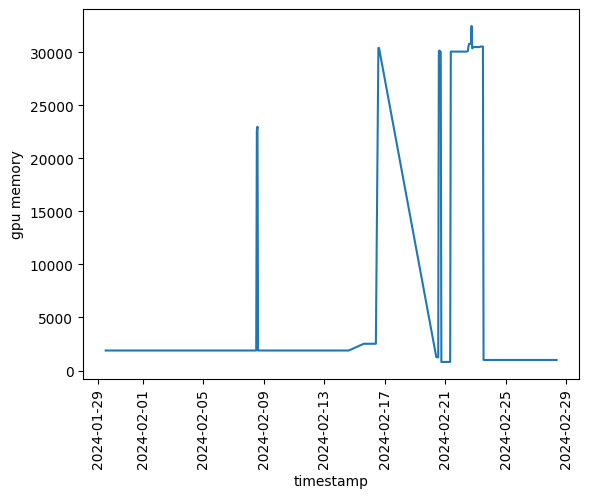

GPU utilization for host 'teach3' 
	between 2024-01-29 13:37:28 and 2024-02-28 09:08:53:


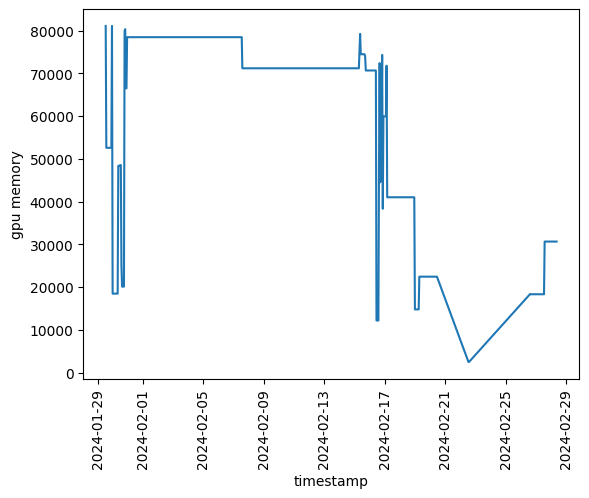

In [34]:
sampling_interval = timedelta(minutes=60)

for host, host_gpu_infos in gpu_info_dict.items():
    title = f"GPU utilization for host '{host}' \n\tbetween {host_gpu_infos['timestamp'].min()} and {host_gpu_infos['timestamp'].max()}:"
    show_gpu_utilization(host_gpu_infos, title)

GPU utilization for all hosts 
	between 2024-01-29 13:37:27 and 2024-02-28 09:08:53:


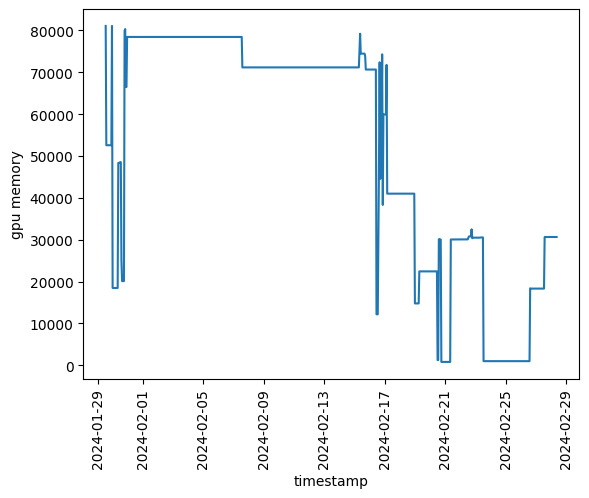

In [35]:
sampling_interval = timedelta(minutes=60)

title = f"GPU utilization for all hosts \n\tbetween {gpu_infos['timestamp'].min()} and {gpu_infos['timestamp'].max()}:"
show_gpu_utilization(gpu_infos, title)

GPU utilization for all processes started by root 
	between 2024-01-29 13:37:27 and 2024-02-20 15:12:51:


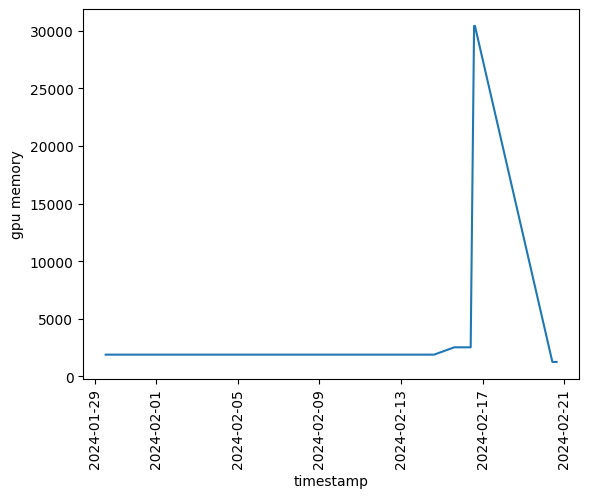

GPU utilization for all processes started by non-root users 
	between 2024-01-29 13:37:27 and 2024-02-20 15:12:51:


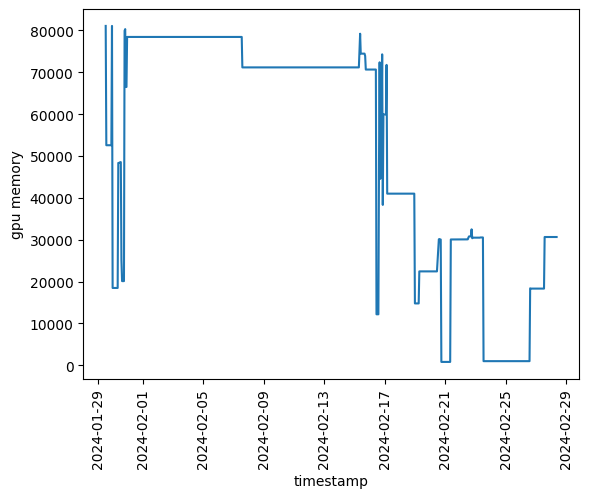

In [36]:
# When calling pd.merge, the kernel dies. likely due to memory reasons. 
# combined_resource_infos = pd.merge(gpu_infos, process_infos, left_on="pid", right_on="pid")
# The following filtering logic serves as a workaround.

root_pids = process_infos.loc[process_infos["user"] == "root"]["pid"].tolist()
non_root_pids = process_infos.loc[process_infos["user"] != "root"]["pid"].tolist()

root_gpu_infos = gpu_infos.loc[gpu_infos["pid"].isin(root_pids)]
non_root_gpu_infos = gpu_infos.loc[gpu_infos["pid"].isin(non_root_pids)]

title = f"GPU utilization for all processes started by root \n\tbetween {root_gpu_infos['timestamp'].min()} and {root_gpu_infos['timestamp'].max()}:"
show_gpu_utilization(root_gpu_infos, title)

title = f"GPU utilization for all processes started by non-root users \n\tbetween {root_gpu_infos['timestamp'].min()} and {root_gpu_infos['timestamp'].max()}:"
show_gpu_utilization(non_root_gpu_infos, title)

Stackplot of root vs non-root gpu utilization 
	between 2024-01-29 13:00:00 and 2024-02-20 15:00:00:


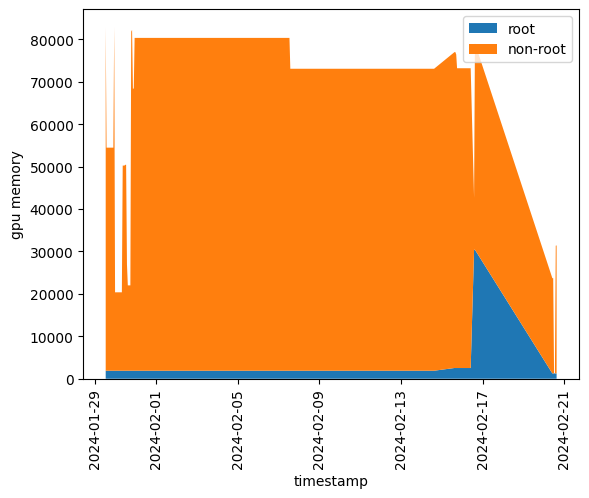

In [45]:
sampling_interval = timedelta(minutes=60)

root_pids = process_infos.loc[process_infos["user"] == "root"]["pid"].unique().tolist()
root_gpu_infos = gpu_infos.loc[gpu_infos["pid"].isin(root_pids)]
root_gpu_memory_infos = root_gpu_infos[["timestamp", "gpu_memory"]]
root_gpu_memory_infos = root_gpu_memory_infos.groupby("timestamp").max()
root_gpu_memory_infos.reset_index(inplace = True) 
root_gpu_memory_infos = root_gpu_memory_infos.set_index("timestamp").resample(sampling_interval).max()
root_gpu_memory_infos.dropna(subset=["gpu_memory"], inplace=True)

non_root_pids = process_infos.loc[process_infos["user"] != "root"]["pid"].unique().tolist()
non_root_gpu_infos = gpu_infos.loc[gpu_infos["pid"].isin(non_root_pids)]
non_root_gpu_memory_infos = non_root_gpu_infos[["timestamp", "gpu_memory"]]
non_root_gpu_memory_infos = non_root_gpu_memory_infos.groupby("timestamp").max()
non_root_gpu_memory_infos.reset_index(inplace = True) 
non_root_gpu_memory_infos = non_root_gpu_memory_infos.set_index("timestamp").resample(sampling_interval).max()
root_gpu_memory_infos.dropna(subset=["gpu_memory"], inplace=True)

df = pd.merge_asof(root_gpu_memory_infos, non_root_gpu_memory_infos, on="timestamp")
df = df.fillna(0)

y_stack = np.vstack([df["gpu_memory_x"], df["gpu_memory_y"]])

ax = plt.subplot()
ax.stackplot(df["timestamp"], y_stack)

ax.set_xlabel("timestamp")
ax.set_ylabel("gpu memory")
ax.xaxis_date()

print(f"Stackplot of root vs non-root gpu utilization \n\tbetween {df['timestamp'].min()} and {df['timestamp'].max()}:")

plt.legend(["root", "non-root"])
plt.xticks(rotation=90)
plt.show()


In [64]:
N = 10

sorted_gpu_infos = gpu_infos.sort_values(by=["gpu_memory"], ascending=False)
top_n_gpu_pids = sorted_gpu_infos["pid"].unique().tolist()[:N]

print(f"Top {N} gpu intensive processes:")

for pid in top_n_gpu_pids:
    pid_process_infos = process_infos.loc[process_infos["pid"] == pid]

    max_gpu_memory = sorted_gpu_infos.loc[sorted_gpu_infos["pid"] == pid]["gpu_memory"].max()

    started = pid_process_infos["timestamp"].min()
    ended = pid_process_infos["timestamp"].max() 
    user = pid_process_infos["user"].tolist()[0]
    cmd = pid_process_infos["cmd"].tolist()[0]

    print(f"\nProcess: {pid}:")
    print(f"\tUser: {user}")
    print(f"\tCommand: {cmd}")
    print(f"\tStarted at: {started}")
    print(f"\tEnded at: {ended}")
    print(f"\tMax GPU Memory: {max_gpu_memory}")



Top 10 gpu intensive processes:

Process: 1830337:
	User: joerg
	Command: /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-35358a6b-d21c-4c45-a6bf-c5a29923b948.json
	Started at: 2024-01-29 13:44:57
	Ended at: 2024-01-29 13:45:56
	Max GPU Memory: 81088

Process: 2154445:
	User: joerg
	Command: /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-5e3eddd5-a625-4801-bfc3-3ee08fc659ad.json
	Started at: 2024-01-29 23:26:58
	Ended at: 2024-01-29 23:35:02
	Max GPU Memory: 81082

Process: 1823085:
	User: joerg
	Command: /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-35358a6b-d21c-4c45-a6bf-c5a29923b948.json
	Started at: 2024-01-29 13:37:28
	Ended at: 2024-01-29 13:37:28
	Max GPU Memory: 80890

Process: 1832701:
	User: joerg
	Command: /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-35358a6b-d21c-4c45-a6bf-c5a29923b948.json
	Started at: 2024-01-29 13:47:26
	E